In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio   #For loading MATLAB .mat file

## Segmentation-less Digital Rock Physics 

This notebook illustrates the workflow of the segmentation-less without target (SLOT) method introduced by Ikeda et. al. (2020). More information could be found on https://doi.org/10.1029/2019JB018680.
Digital Rock Physics (DRP) allows geoscientists to simulate common laboratory experiments on digital rock samples obtained by means of Computed Tomography (CT) scan. A CT-scanner records numerous X-ray projections of a sample, which captures the spatial distribution of X-ray attenuation. Those projections are then used to reconstruct a three-dimensional volume of the sample (i.e., CT-volume). As a first-order approximation, the X-ray attenuation of material is proportional to its density. Hence, geoscientists can distinguish between minerals and pore spaces by, for example, examining the differences in X-ray attenuation magnitude in different regions. The X-ray attenuation is usually scaled in a unit called “CT-number,” where high CT-number represents dense material, and vice versa.  
In order to perform a “digital experiment” on a “digital sample”, the CT volume must be converted from the unit of X-ray attenuation to physical properties. For example, to estimate the effective elastic properties of the sample, we need a distribution of elastic moduli at each location. Several methods have been proposed to transform CT-number to elastic moduli. In this work, we consider the segmentation-less method where CT-number is successively converted to elastic moduli. 

First, the CT-number of the sample is compared with the CT-number of known density materials (i.e., targets). A least-square approximation is used to approximate a function that links the CT-number to density (kg/m^3). Applying such a function, we map the CT-volume into a density volume. Next, the density volume is converted to porosity volume by the inversely linear relationship between density and porosity. Finally, the porosity volume is transformed into elastic properties volume utilizing an effective medium theory. After that, numerical simulation could be performed on the sample (see an example image below).


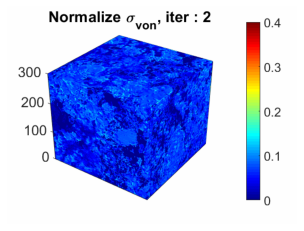

In [14]:
img = plt.imread("animation.gif")

fig, ax = plt.subplots()
plt.imshow(img)
ax.axis('off');

## Segmentation-less without Targets (SLOT)

The next section of this notebook describes the Segmentation-less without targets method. This method is used when targets are not presented in the dataset. Instead, we define imaginary targets called pseudo targets. The CT-number of pseudotargets are defined from local-extrema histograms. 

In [2]:
#Function declaration 
def locateExtrema(CT, e):
    #Locate local extrema point 
    #Input --> A [3D np array]: A CT-image, e [positive integer] --> subcube size of (2e + 1)
    #Output --> localMaximaList, localMinimaList
    #           A [N-by-4 numpy] Each row represents the location and value of local maxima (or minima).
    #                            The first, second, and third value in each row are the location of the point with respect to 
    #                            the first, second, and third axis coordinate. 
    #Also output padCT if needed 
    #Note: This is a O(N^3) algorithm. Could be further improve with dynamic programming 
    
    e = int(e)    #Make sure that e is an integer
    
    #pad the cube with Nan
    padCT = np.full((CT.shape[0]+2*e, CT.shape[1]+2*e, CT.shape[2]+2*e), np.nan)
    padCT[e:CT.shape[0]+e, e:CT.shape[1]+e, e:CT.shape[2]+e] = CT
    
    localMaximaList = []
    localMinimaList = []
    
    #Loop through the CT-cube
    for i in range(e, CT.shape[0]+e):
        for j in range(e, CT.shape[1]+e):
            for k in range(e, CT.shape[2]+e):
                #Grab the center value
                center = padCT[i, j, k]
                
                #Grab a small subcube area
                subCube = padCT[i-e:i+e, j-e:j+e, k-e:k+e]
                
                #comparison
                if center == np.nanmax(subCube.flatten()):
                    localMaximaList.append([i, j, k, padCT[i, j, k]])
                elif center == np.nanmin(subCube.flatten()):
                    localMinimaList.append([i, j, k, padCT[i, j, k]])
                    
    localMaximaList = np.array(localMaximaList)
    localMinimaList = np.array(localMinimaList)    
    
    return localMaximaList, localMinimaList, padCT

## Test the algorithm with a random image 

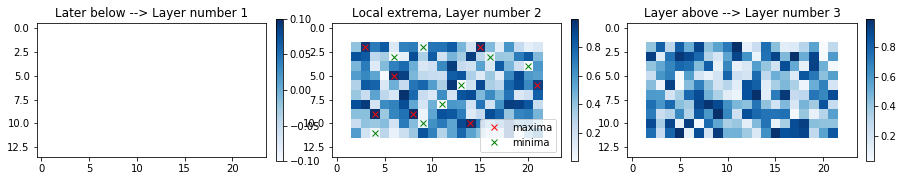

In [3]:
CT = np.random.rand(10, 20, 30)
epsilon = [2]

for e in epsilon:
    localMaximaList, localMinimaList, padCT = locateExtrema(CT, e)

##### Plotting #####
#Display output
layerNumber = 2
plt.figure(figsize = (15, 8))
plt.subplot(1, 3, 1)
im = plt.imshow(padCT[:, :, layerNumber-1], cmap = 'Blues')
plt.title('Later below --> Layer number {}'.format(layerNumber-1))
plt.colorbar(im, fraction=0.029, pad=0.04)

plt.subplot(1, 3, 2)
im = plt.imshow(padCT[:, :, layerNumber], cmap = 'Blues')
plt.plot(localMaximaList[localMaximaList[:, 2] == layerNumber, 1], localMaximaList[localMaximaList[:, 2] == layerNumber, 0], 'rx')
plt.plot(localMinimaList[localMinimaList[:, 2] == layerNumber, 1], localMinimaList[localMinimaList[:, 2] == layerNumber, 0], 'gx')
plt.title('Local extrema, Layer number {}'.format(layerNumber))
plt.legend(['maxima', 'minima'])
plt.colorbar(im, fraction=0.029, pad=0.04)

plt.subplot(1, 3, 3)
im = plt.imshow(padCT[:, :, layerNumber+1], cmap = 'Blues')
plt.title('Layer above --> Layer number {}'.format(layerNumber+1))
plt.colorbar(im, fraction=0.029, pad=0.04)
plt.show()

Figure 1: A result from the local extrema marking algorithm. The middle figure shows a slice with marked local extrema value. The red markers and the green markers illustrate the location of the local maxima point and local minima point, respectively. The left and the right figure show the layer located below and above the middle layer, respectively.   

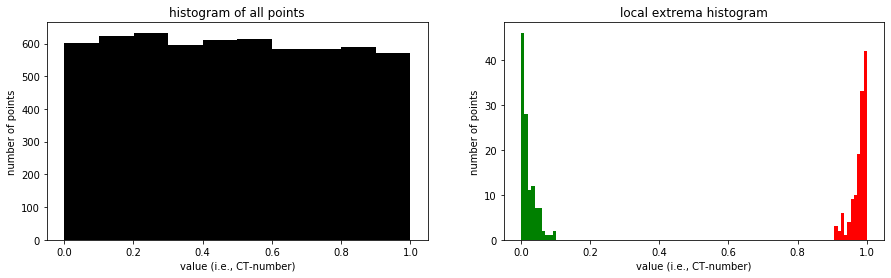

In [4]:
plt.figure(figsize = (15, 4))
plt.subplot(1, 2, 1)
plt.hist(CT.flatten(), bins = 10, color = 'k')
plt.xlabel('value (i.e., CT-number)')
plt.ylabel('number of points')
plt.title('histogram of all points')

plt.subplot(1, 2, 2)
plt.hist(localMinimaList[:, 3], bins = 10, color = 'g')
plt.hist(localMaximaList[:, 3], bins = 10, color = 'r') 
plt.xlabel('value (i.e., CT-number)')
plt.ylabel('number of points')
plt.title('local extrema histogram')

plt.show()

Figure 2: Histogram of all values (i.e., CT-number) and local extrema histogram

## Test with the UT02 sample

Here, we provide a subsample of the UT02 sample. We will show how the local extrema histogram change with epsilon, and, eventually, change the CT-number of pseudotargets. 

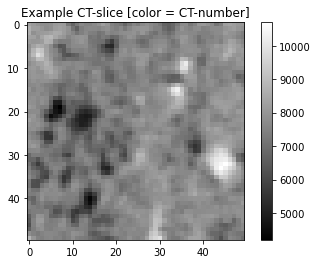

In [15]:
#Load data --> Load .mat file
data = sio.loadmat('subSample_UT02.mat')
CT = data['UT02']

plt.figure()
plt.imshow(CT[:, :, 5], cmap = 'gray')
plt.colorbar()
plt.title('Example CT-slice [color = CT-number]')
plt.show()

Figure 3: An example CT-slice from the UT02 sample. Note that this subsample size is 50x50x50 voxels and is randomly selected from the full sample. 

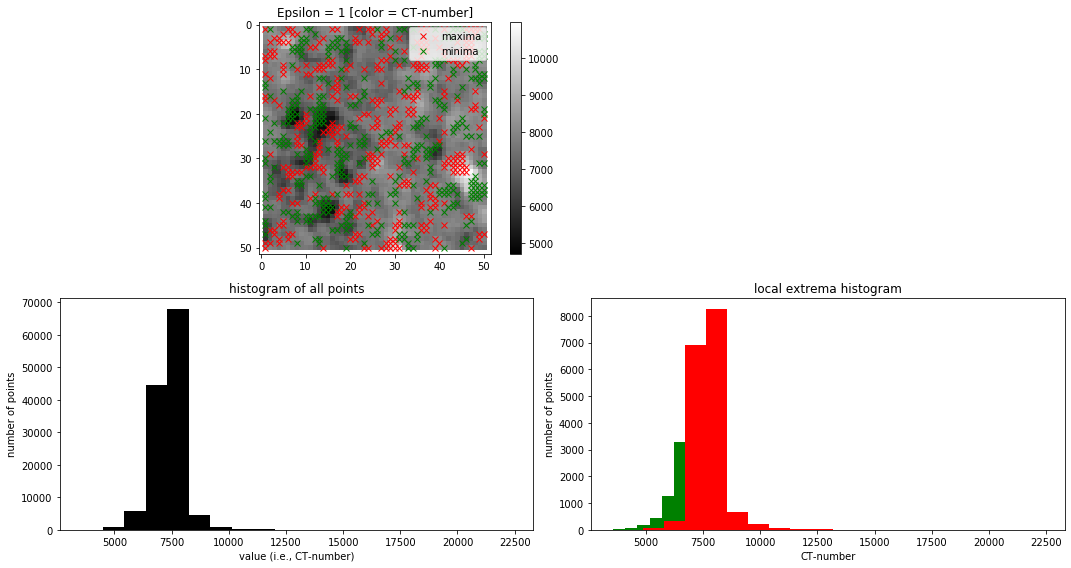

----------------------------------------------------------


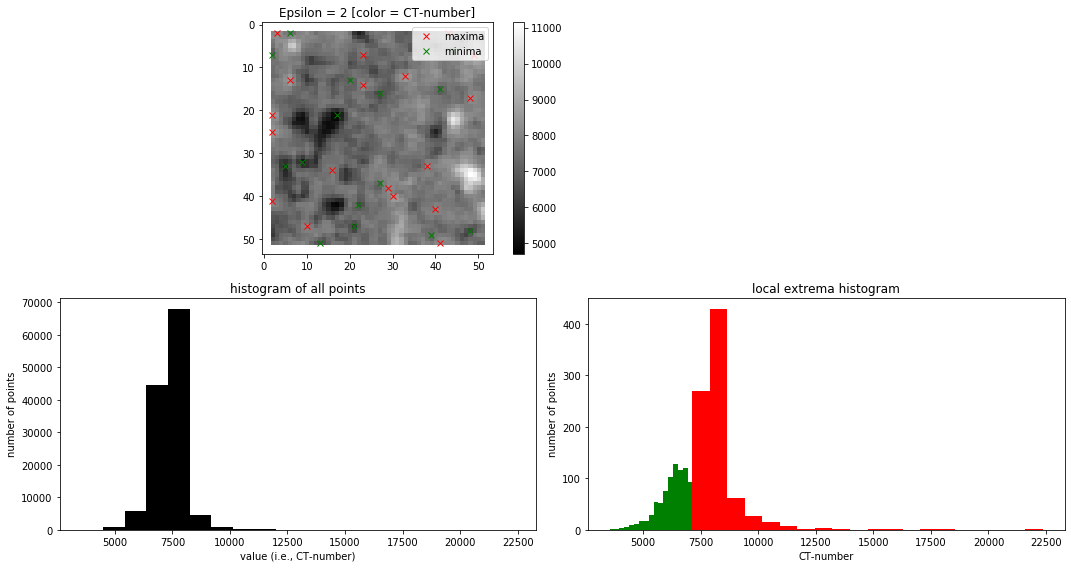

----------------------------------------------------------


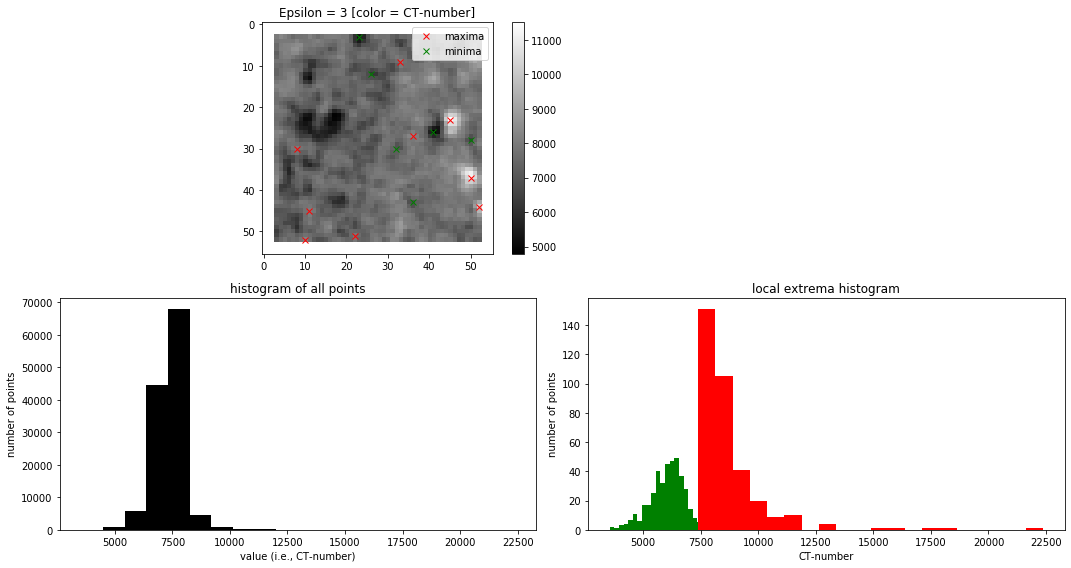

----------------------------------------------------------


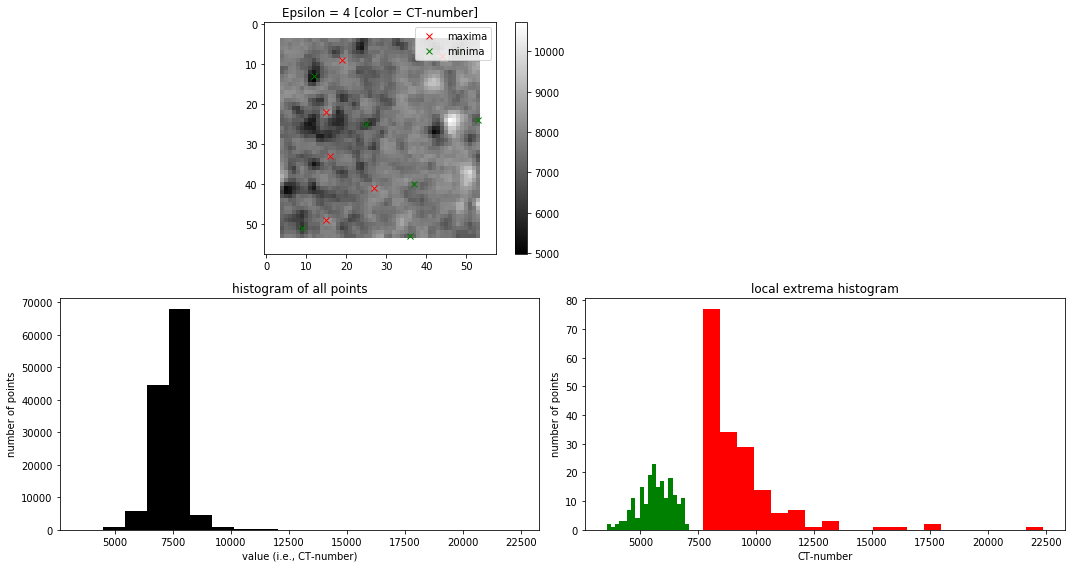

----------------------------------------------------------


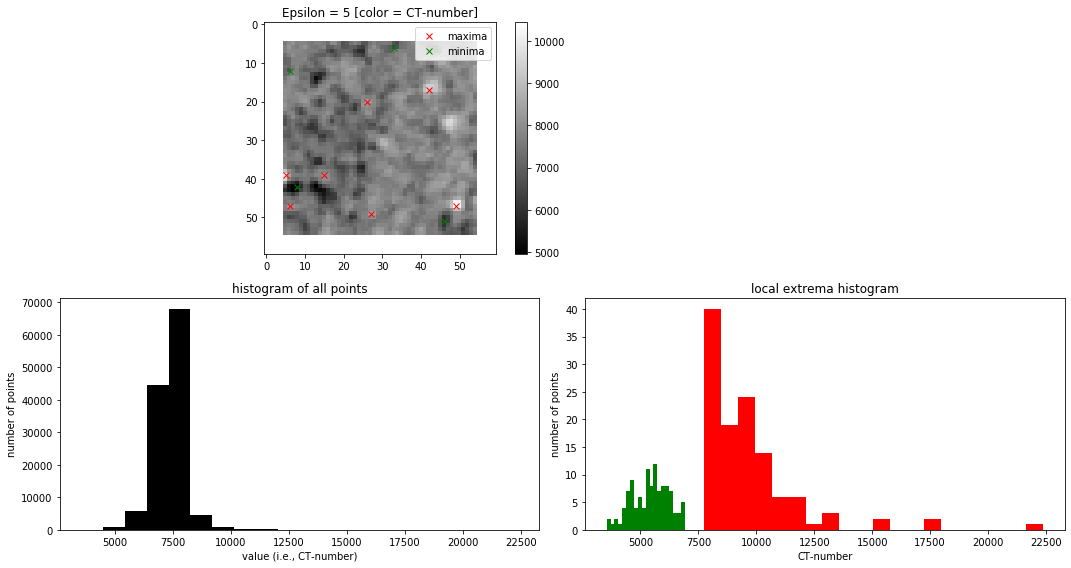

----------------------------------------------------------


In [6]:
epsilon = [1, 2, 3, 4, 5]
layerNumber = 5 
for e in epsilon:
    localMaximaList, localMinimaList, padCT = locateExtrema(CT, e)
    
    #Plotting 
    plt.figure(figsize = (15, 8))
    plt.subplot(2, 2, 1)
    im = plt.imshow(padCT[:, :, layerNumber], cmap = 'gray')
    plt.plot(localMaximaList[localMaximaList[:, 2] == layerNumber, 1], localMaximaList[localMaximaList[:, 2] == layerNumber, 0], 'rx')
    plt.plot(localMinimaList[localMinimaList[:, 2] == layerNumber, 1], localMinimaList[localMinimaList[:, 2] == layerNumber, 0], 'gx')
    plt.title('Epsilon = {} [color = CT-number]'.format(e))
    plt.legend(['maxima', 'minima'], loc = 'upper right')
    plt.colorbar(im, fraction=0.05, pad=0.04)
    
    plt.subplot(2, 2, 3)
    plt.hist(CT.flatten(), bins = 20, color = 'k')
    plt.xlabel('value (i.e., CT-number)')
    plt.ylabel('number of points')
    plt.title('histogram of all points')

    plt.subplot(2, 2, 4)
    plt.hist(localMinimaList[:, 3], bins = 20, color = 'g')
    plt.hist(localMaximaList[:, 3], bins = 20, color = 'r') 
    plt.xlabel('CT-number')
    plt.ylabel('number of points')
    plt.title('local extrema histogram')
    
    plt.tight_layout()
    plt.show()
    
    print('----------------------------------------------------------')

Figure 4: Local extrema histograms vs epsilon from epsilon = 1 - 5. Due to the small sample size, we start seeing the local minima histogram "breaking" down. This should not happen if we decrease the number of bins or increase the sample size.

## Conversion of CT-images to Elastic Properties volumes

(Please run the code in the full dataset). Now, after the CT-number of the pseudotargets have beeen defined we convert the CT-images into density image according to equation (3) in the manuscript. Then, subsequential transformations could be performed.

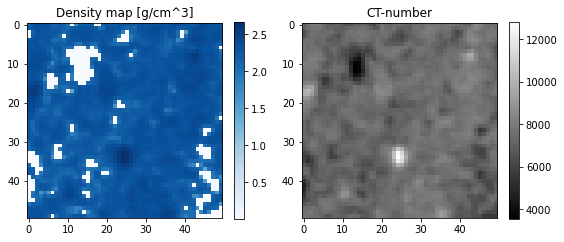

In [112]:
def CT2Density(volume):
    # volume in CT-number unit
    # density in g/cm^3 unit 
    volume[volume < 6577] = 6577  #block nan in python 
    density =  1.322*(volume - 6577)**0.080 + 0.0092    
    density[density <= 0.0] = 0.0
    return density

densityVolume = CT2Density(CT.astype(float))

fig, ax = plt.subplots(1, 2, figsize = (8, 14))
p1 = ax[0].imshow(densityVolume[:, :, 20], cmap = 'Blues')
ax[0].set_title('Density map [g/cm^3]')
fig.colorbar(p1, ax = ax[0], shrink=0.20)

p2 = ax[1].imshow(CT[:, :, 20], cmap = 'gray')
ax[1].set_title('CT-number')
fig.colorbar(p2, ax = ax[1], shrink=0.20)

plt.tight_layout()

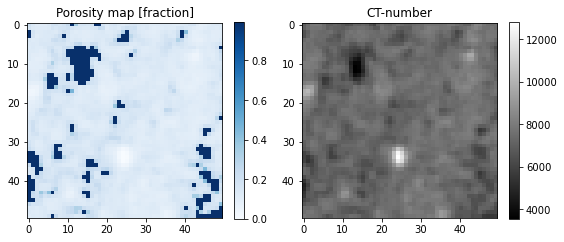

In [113]:
def Density2Poroity(density):
    # density in (g/cm^3) unit
    # porosity in fraction [0 - 1] unit
    
    #Linear interpolation between quartz (2.65 g/cm^3) -> 0 porosity 
    #and air (0 g/cm^3) -> 1 porosity 
    porosity = 1.0 - (1.0/2.65 * density)
    
    porosity[porosity <= 0.0] = 0.0
    porosity[porosity >= 1.0] = 1.0
    return porosity

porosityVolume = Density2Poroity(densityVolume.astype(float))

fig, ax = plt.subplots(1, 2, figsize = (8, 14))

p1 = ax[0].imshow(porosityVolume[:, :, 20], cmap = 'Blues')
ax[0].set_title('Porosity map [fraction]')
fig.colorbar(p1, ax = ax[0], shrink=0.20)

p2 = ax[1].imshow(CT[:, :, 20], cmap = 'gray')
ax[1].set_title('CT-number')
fig.colorbar(p2, ax = ax[1], shrink=0.20)

plt.tight_layout()

In [114]:
def HS(K1, G1, K2, G2, porosity, cp = 1.0):
    """
    Hashin-Shtrikman bound (Hashin and Shtrikman, 1963) and 
    Modified upper Hashin-Shtrikman bound (Nur et. al., 1998)
    for two-phase rock 
    
    Parameters
    ----------
    K1, G1  [float]     
        Bulk (K) and shear (G) modulus of mineral 1 (solid).
    K2, G2  [float]    
        Bulk (K) and shear (G) modulus of mineral 2 (fluid).
    porosity [np array] 
        1D numpy array contains the fractional porosity where you want to evaluate HS.
        porosity = 0 means 100% phase 1 + 0% phase 2
    
    cp      [float] (optional)
        Critical fractional porosity (default = 1.0).
    
    Returns
    -------
    UHS_K, UHS_G [np array]  
        1D numpy arrays contains the UPPER bound bulk and shear modulus of samples 
        whose porosity is defined by the porosity variable.
    LHS_K, LHS_G [np array]  (does not return if CP < 1.0)
        1D numpy arrays contains the Lower bound bulk and shear modulus of samples 
        whose porosity is defined by the porosity variable.
    Examples
    --------
    >>> UHS_K, UHS_G, LHS_K, LHS_G = rp.HS(36e9, 44e9, 1.0e6, 1e-6, 0)
    UHS_K --> 36000000000
    UHS_G --> 44000000000
    LHS_K --> 36000000000
    LHS_G --> 44000000000
    >>> UHS_K, UHS_G, LHS_K, LHS_G = rp.HS(36e9, 44e9, 1.0e6, 1, 1)
    UHS_K --> 1000000.0 
    UHS_G --> 1.0 
    LHS_K --> 1000000.0 
    LHS_G --> 1.0
    >>> UHS_K, UHS_G, LHS_K, LHS_G = rp.HS(36e9, 44e9, 1.0e6, 1, [0.25, 0.75])
    UHS_K --> [2.34093563e+10 6.16433999e+09]
    UHS_G --> [2.58793503e+10 6.02593193e+09]
    LHS_K --> [3999670.69355336 1333321.43218016]
    LHS_G --> [8.499995   1.83333278]
       
    References
    ----------
    .. [1] Nur, A., G. Mavko, J. Dvorkin, and D. Galmudi, 1998, Critical porosity: 
        A key to relating physical properties to porosity in rocks: The Leading 
        Edge, 17, 357–362.
    """

    #data preconditioning
    if G1 < 1e-12: 
        warnings.warn('Mineral 1 shear modulus < 1e-12')
        G1 = 1e-12
    if G2 < 1e-12:
        warnings.warn('Mineral 2 shear modulus < 1e-12')
        G2 = 1e-12           


    phi = porosity.copy()/cp
    if np.abs(cp - 1.0) < 1e-12:
        #HS bound
        UHS_K = K1 + phi/((K2 - K1)**(-1.0) + (1.0 - phi)/(K1 + 4.0/3.0*(G1)))
        UHS_G = G1 + phi/((G2-G1)**(-1.0) + (2.0*(1.0-phi)*(K1 + 2.0*G1))/(5.0*G1*(K1 + 4.0/3.0 * G1)))
        LHS_K = K2 + (1-phi)/((K1 - K2)**(-1.0) + phi/(K2 + 4.0/3.0*(G2)))
        LHS_G = G2 + (1-phi)/((G1-G2)**(-1.0) + (2.0*(phi)*(K2 + 2.0*G2))/(5.0*G2*(K2 + 4.0/3.0 * G2)))

        return UHS_K, UHS_G, LHS_K, LHS_G
    else:
        #Modulus at the fluid ended member
        Kfluid_phiC = K2 + (1-cp)/((K1 - K2)**(-1.0) + cp/(K2 + 4.0/3.0*(G2)))
        Gfluid_phiC = G2 + (1-cp)/((G1-G2)**(-1.0) + (2.0*(cp)*(K2 + 2.0*G2))/(5.0*G2*(K2 + 4.0/3.0 * G2)))
        print(Kfluid_phiC)
        #Modified HS bound
        UHS_K = (K1 + phi/((Kfluid_phiC - K1)**(-1.0) + (1.0 - phi)/(K1 + 4.0/3.0*(G1)))) * (porosity <= cp) + \
            (K2 + (1-porosity)/((K1 - K2)**(-1.0) + porosity/(K2 + 4.0/3.0*(G2)))) * (porosity > cp) 

        UHS_G = (G1 + phi/((Gfluid_phiC-G1)**(-1.0) + (2.0*(1.0-phi)*(K1 + 2.0*G1))/(5.0*G1*(K1 + 4.0/3.0 * G1)))) * (porosity <= cp) + \
            (G2 + (1-porosity)/((G1-G2)**(-1.0) + (2.0*(porosity)*(K2 + 2.0*G2))/(5.0*G2*(K2 + 4.0/3.0 * G2)))) * (porosity > cp)
                
        return UHS_K, UHS_G 

2777640.6103426004


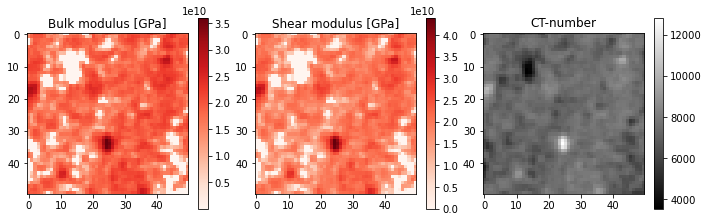

In [123]:
K_volume, G_volume = HS(36.0e9, 44.0e9, 1.0e6, 1.0e-6, porosityVolume, cp = 0.36)

fig, ax = plt.subplots(1, 3, figsize = (10, 18))

p1 = ax[0].imshow(K_volume[:, :, 20], cmap = 'Reds')
ax[0].set_title('Bulk modulus [GPa]')
fig.colorbar(p1, ax = ax[0], shrink=0.15)


p2 = ax[1].imshow(G_volume[:, :, 20], cmap = 'Reds')
ax[1].set_title('Shear modulus [GPa]')
fig.colorbar(p2, ax = ax[1], shrink=0.15)

p3 = ax[2].imshow(CT[:, :, 20], cmap = 'gray')
ax[2].set_title('CT-number')
fig.colorbar(p3, ax = ax[2], shrink=0.15)

plt.tight_layout()